In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import entropy

In [2]:
# Load the CSV file
result_csv_path = './outputs/inference_results/result_eval_KD.csv'
result_bef_csv_path = './outputs/inference_results/result_eval_KD_bef.csv'
df_aft = pd.read_csv(result_csv_path)
df_bef = pd.read_csv(result_bef_csv_path)
# df = df[df["mode"] == "val"]

df = df_aft
df = df[df["mode"] == "test"]
df_bef = df_bef[df_bef["mode"] == "test"]
display(df.head())

,mode,annot_ids,annotation,prob_ensemble,prob_model_0,prob_model_1,prob_model_2,prob_model_3,prob_model_4,prob_model_5,prob_model_6
0,test,113597_2_19990102,0.0,0.461039,0.459278,0.462067,0.459444,0.459156,0.461633,0.463056,0.462637
1,test,203326_1_19990102,0.0,0.485993,0.483017,0.486932,0.486581,0.483621,0.487958,0.488348,0.485491
2,test,203326_4_19990102,0.0,0.476892,0.474396,0.478037,0.475559,0.474748,0.478014,0.479382,0.478109
3,test,203326_3_19990102,0.0,0.508365,0.509147,0.508610,0.508086,0.507283,0.508587,0.509086,0.507755
4,test,203326_2_19990102,0.0,0.559419,0.559555,0.560219,0.560224,0.558629,0.559568,0.559547,0.558187


In [3]:
# Basic statistics
print("\n📝 Basic Statistics")
print(df.describe())


📝 Basic Statistics
        annotation  prob_ensemble  prob_model_0  prob_model_1  prob_model_2  \
count  6163.000000    6163.000000   6163.000000   6163.000000   6163.000000   
mean      0.090054       0.484132      0.482003      0.485331      0.481714   
std       0.286282       0.053364      0.055136      0.052857      0.054412   
min       0.000000       0.278069      0.268986      0.280589      0.272972   
25%       0.000000       0.450796      0.447919      0.452290      0.447677   
50%       0.000000       0.470342      0.468309      0.471790      0.467394   
75%       0.000000       0.508358      0.507494      0.509291      0.506329   
max       1.000000       0.733188      0.735750      0.732756      0.733821   

       prob_model_3  prob_model_4  prob_model_5  prob_model_6  
count   6163.000000   6163.000000   6163.000000   6163.000000  
mean       0.481490      0.485013      0.486900      0.486476  
std        0.053922      0.052842      0.052466      0.052022  
min        0

In [4]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
ensemble_col = 'prob_ensemble'
model_cols = [col for col in df.columns if col.startswith('prob_model_')]


📊 AUROC Scores (with 95% CI)
prob_model_0 AUROC: 0.7952 (95% CI: 0.7724 - 0.8179)
prob_model_1 AUROC: 0.7966 (95% CI: 0.7739 - 0.8193)
prob_model_2 AUROC: 0.7978 (95% CI: 0.7751 - 0.8205)
prob_model_3 AUROC: 0.7952 (95% CI: 0.7724 - 0.8180)
prob_model_4 AUROC: 0.7978 (95% CI: 0.7751 - 0.8205)
prob_model_5 AUROC: 0.7975 (95% CI: 0.7748 - 0.8202)
prob_model_6 AUROC: 0.7968 (95% CI: 0.7741 - 0.8195)
prob_ensemble AUROC: 0.7967 (95% CI: 0.7740 - 0.8194)


/tmp/ipykernel_276749/3366591457.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")
/tmp/ipykernel_276749/3366591457.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")


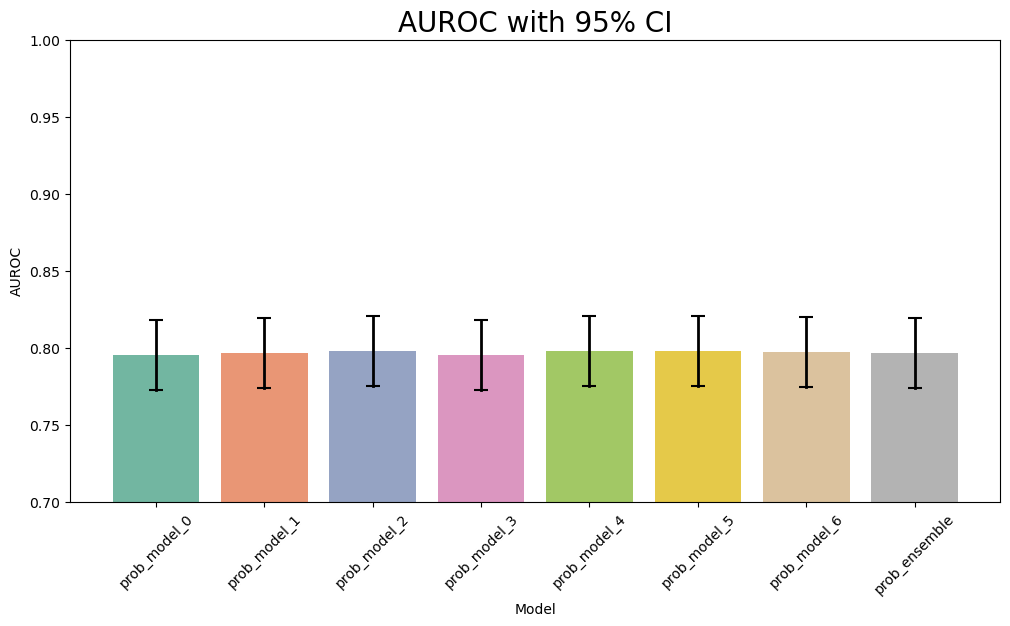

In [5]:
df = df_aft

# Calculate AUROC scores with 95% CI
print("\n📊 AUROC Scores (with 95% CI)")
y_true = df['annotation']
auroc_scores = {}
auroc_cis = {}
for col in model_cols + [ensemble_col]:
    # Calculate AUROC
    auroc = roc_auc_score(y_true, df[col])
    auroc_scores[col] = auroc
    
    # Calculate 95% CI using DeLong method approximation
    n1 = sum(y_true == 1)
    n2 = sum(y_true == 0)
    q1 = auroc / (2 - auroc)
    q2 = 2 * (auroc ** 2) / (1 + auroc)
    se = np.sqrt((auroc * (1 - auroc) + (n1 - 1) * (q1 - auroc**2) + (n2 - 1) * (q2 - auroc**2)) / (n1 * n2))
    ci_lower = auroc - 1.96 * se
    ci_upper = auroc + 1.96 * se
    auroc_cis[col] = (ci_lower, ci_upper)
    
    print(f'{col} AUROC: {auroc:.4f} (95% CI: {ci_lower:.4f} - {ci_upper:.4f})')

# Plot AUROC with 95% CI
plt.figure(figsize=(12, 6))
auroc_df = pd.DataFrame(auroc_scores.items(), columns=["Model", "AUROC"])
auroc_df["CI Lower"], auroc_df["CI Upper"] = zip(*auroc_cis.values())
sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")
for i, (ci_lower, ci_upper) in enumerate(auroc_cis.values()):
    plt.plot([i, i], [ci_lower, ci_upper], color="black", linewidth=2)
    plt.scatter([i], [ci_lower], color="black", marker="_", s=100)
    plt.scatter([i], [ci_upper], color="black", marker="_", s=100)
plt.title("AUROC with 95% CI", fontsize=20)
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)
plt.show()


📊 AUROC Scores (with 95% CI)
prob_model_0 AUROC: 0.7976 (95% CI: 0.7750 - 0.8203)
prob_model_1 AUROC: 0.7705 (95% CI: 0.7469 - 0.7941)
prob_model_2 AUROC: 0.7901 (95% CI: 0.7671 - 0.8130)
prob_model_3 AUROC: 0.7656 (95% CI: 0.7418 - 0.7893)
prob_model_4 AUROC: 0.7826 (95% CI: 0.7594 - 0.8058)
prob_model_5 AUROC: 0.7964 (95% CI: 0.7737 - 0.8191)
prob_model_6 AUROC: 0.8020 (95% CI: 0.7795 - 0.8245)
prob_ensemble AUROC: 0.7995 (95% CI: 0.7769 - 0.8221)


/tmp/ipykernel_276749/2889927555.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")
/tmp/ipykernel_276749/2889927555.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")


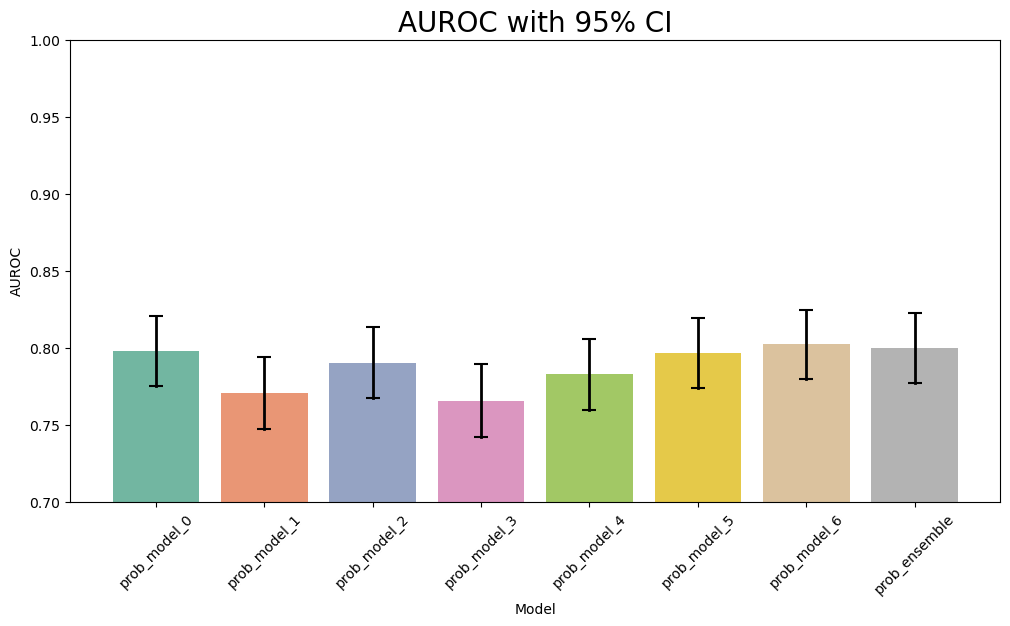

In [6]:
df = df_bef

# Calculate AUROC scores with 95% CI
print("\n📊 AUROC Scores (with 95% CI)")
y_true = df['annotation']
auroc_scores = {}
auroc_cis = {}
for col in model_cols + [ensemble_col]:
    # Calculate AUROC
    auroc = roc_auc_score(y_true, df[col])
    auroc_scores[col] = auroc
    
    # Calculate 95% CI using DeLong method approximation
    n1 = sum(y_true == 1)
    n2 = sum(y_true == 0)
    q1 = auroc / (2 - auroc)
    q2 = 2 * (auroc ** 2) / (1 + auroc)
    se = np.sqrt((auroc * (1 - auroc) + (n1 - 1) * (q1 - auroc**2) + (n2 - 1) * (q2 - auroc**2)) / (n1 * n2))
    ci_lower = auroc - 1.96 * se
    ci_upper = auroc + 1.96 * se
    auroc_cis[col] = (ci_lower, ci_upper)
    
    print(f'{col} AUROC: {auroc:.4f} (95% CI: {ci_lower:.4f} - {ci_upper:.4f})')

# Plot AUROC with 95% CI
plt.figure(figsize=(12, 6))
auroc_df = pd.DataFrame(auroc_scores.items(), columns=["Model", "AUROC"])
auroc_df["CI Lower"], auroc_df["CI Upper"] = zip(*auroc_cis.values())
sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")
for i, (ci_lower, ci_upper) in enumerate(auroc_cis.values()):
    plt.plot([i, i], [ci_lower, ci_upper], color="black", linewidth=2)
    plt.scatter([i], [ci_lower], color="black", marker="_", s=100)
    plt.scatter([i], [ci_upper], color="black", marker="_", s=100)
plt.title("AUROC with 95% CI", fontsize=20)
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)
plt.show()

In [7]:
df = df_aft


📊 Sensitivity and Specificity at 95% Thresholds
prob_model_0 - Sensitivity (95% Specificity): 0.3207, Specificity (95% Sensitivity): 0.1890
prob_model_1 - Sensitivity (95% Specificity): 0.3117, Specificity (95% Sensitivity): 0.2002
prob_model_2 - Sensitivity (95% Specificity): 0.3171, Specificity (95% Sensitivity): 0.1781
prob_model_3 - Sensitivity (95% Specificity): 0.3135, Specificity (95% Sensitivity): 0.1872
prob_model_4 - Sensitivity (95% Specificity): 0.3135, Specificity (95% Sensitivity): 0.2106
prob_model_5 - Sensitivity (95% Specificity): 0.3153, Specificity (95% Sensitivity): 0.2063
prob_model_6 - Sensitivity (95% Specificity): 0.3135, Specificity (95% Sensitivity): 0.1885
prob_ensemble - Sensitivity (95% Specificity): 0.3153, Specificity (95% Sensitivity): 0.1951


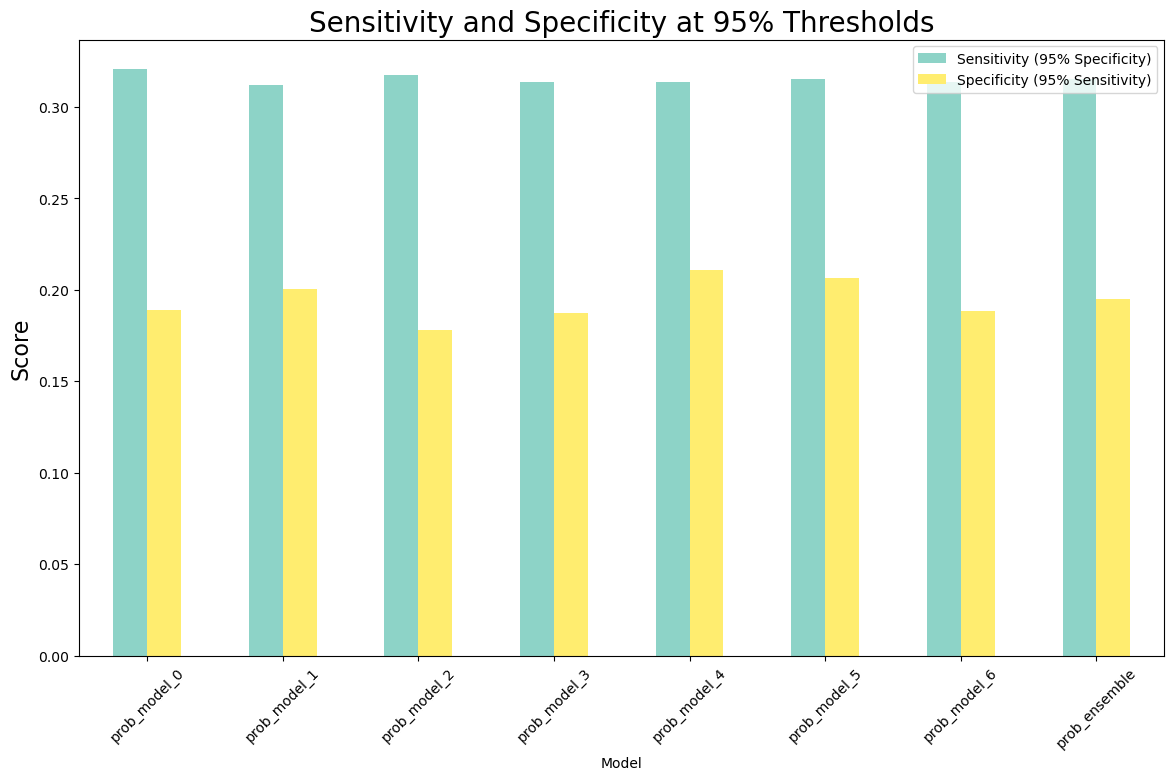

In [8]:
y_true = df['annotation']

# Sensitivity at 95% Specificity & Specificity at 95% Sensitivity
print("\n📊 Sensitivity and Specificity at 95% Thresholds")
threshold_metrics = {}
for col in model_cols + [ensemble_col]:
    fpr, tpr, thresholds = roc_curve(y_true, df[col])

    # Sensitivity at 95% Specificity
    specificity_threshold_idx = np.where(1 - fpr >= 0.95)[0]
    if len(specificity_threshold_idx) > 0:
        sensitivity_95 = max(tpr[specificity_threshold_idx])
    else:
        sensitivity_95 = np.nan  # 또는 0으로 처리

    # Specificity at 95% Sensitivity
    sensitivity_threshold_idx = np.where(tpr >= 0.95)[0]
    if len(sensitivity_threshold_idx) > 0:
        specificity_95 = max(1 - fpr[sensitivity_threshold_idx])
    else:
        specificity_95 = np.nan  # 또는 0으로 처리

    threshold_metrics[col] = (sensitivity_95, specificity_95)
    print(f"{col} - Sensitivity (95% Specificity): {sensitivity_95:.4f}, Specificity (95% Sensitivity): {specificity_95:.4f}")

# Plot Sensitivity and Specificity
threshold_df = pd.DataFrame(threshold_metrics.items(), columns=["Model", "Metrics"])
threshold_df["Sensitivity (95% Specificity)"], threshold_df["Specificity (95% Sensitivity)"] = zip(*threshold_df["Metrics"])
threshold_df.drop(columns=["Metrics"], inplace=True)
threshold_df.set_index("Model", inplace=True)
threshold_df.plot(kind="bar", figsize=(14, 8), colormap="Set3")
plt.title("Sensitivity and Specificity at 95% Thresholds", fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("Score", fontsize=16)
# plt.ylim(0.2, 1.0)
plt.show()


📊 AUROC Scores
prob_model_0 AUROC: 0.7952
prob_model_1 AUROC: 0.7966
prob_model_2 AUROC: 0.7978
prob_model_3 AUROC: 0.7952
prob_model_4 AUROC: 0.7978
prob_model_5 AUROC: 0.7975
prob_model_6 AUROC: 0.7968
prob_ensemble AUROC: 0.7967


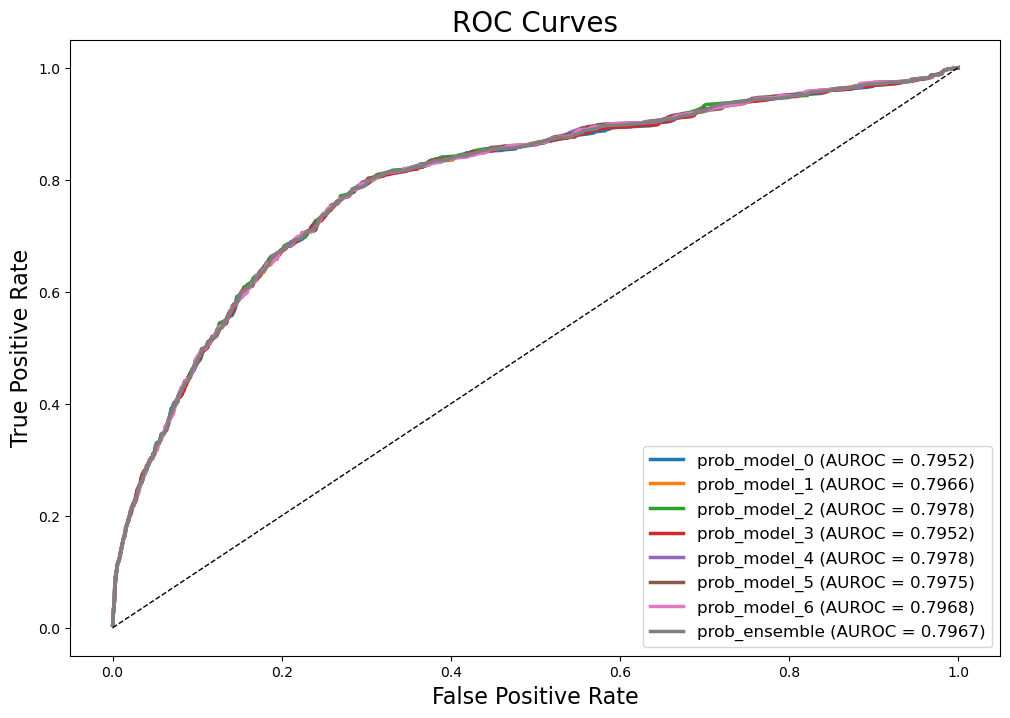

In [9]:
# Calculate AUROC scores
print("\n📊 AUROC Scores")
y_true = df['annotation']
auroc_scores = {}
for col in model_cols + [ensemble_col]:
    auroc_scores[col] = roc_auc_score(y_true, df[col])
    print(f'{col} AUROC: {auroc_scores[col]:.4f}')

# Plot ROC curves (Seaborn)
plt.figure(figsize=(12, 8))
for col in model_cols + [ensemble_col]:
    fpr, tpr, _ = roc_curve(y_true, df[col])
    sns.lineplot(x=fpr, y=tpr, label=f'{col} (AUROC = {auroc_scores[col]:.4f})', linewidth=2.5)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title('ROC Curves', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.show()


🔗 Correlation Matrix


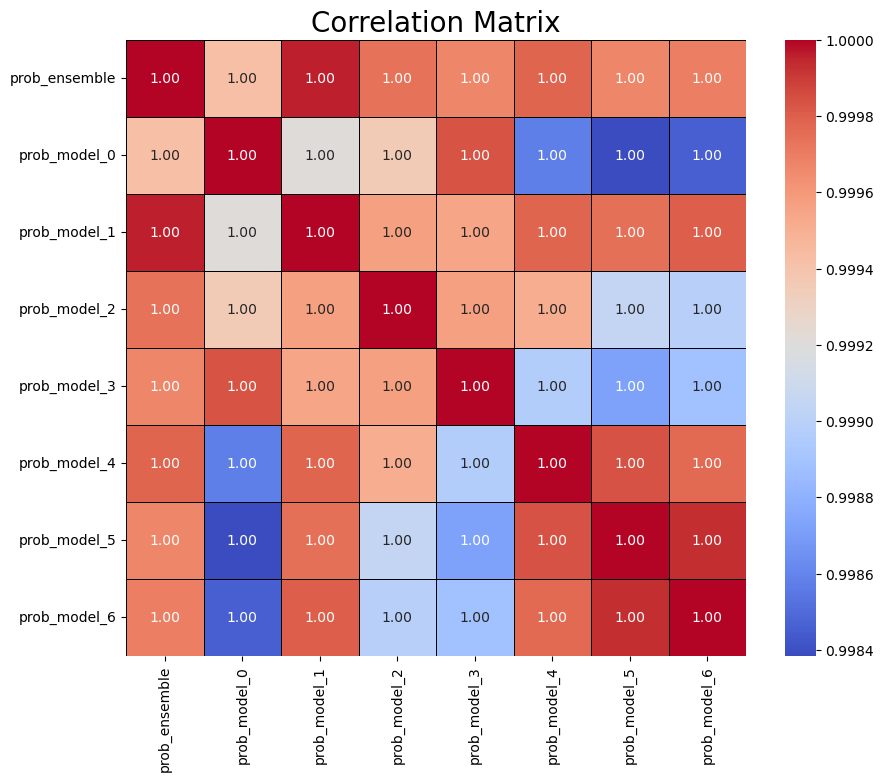

In [10]:
# Correlation matrix (Seaborn)
print("\n🔗 Correlation Matrix")
corr_matrix = df[[ensemble_col] + model_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix', fontsize=20)
plt.show()

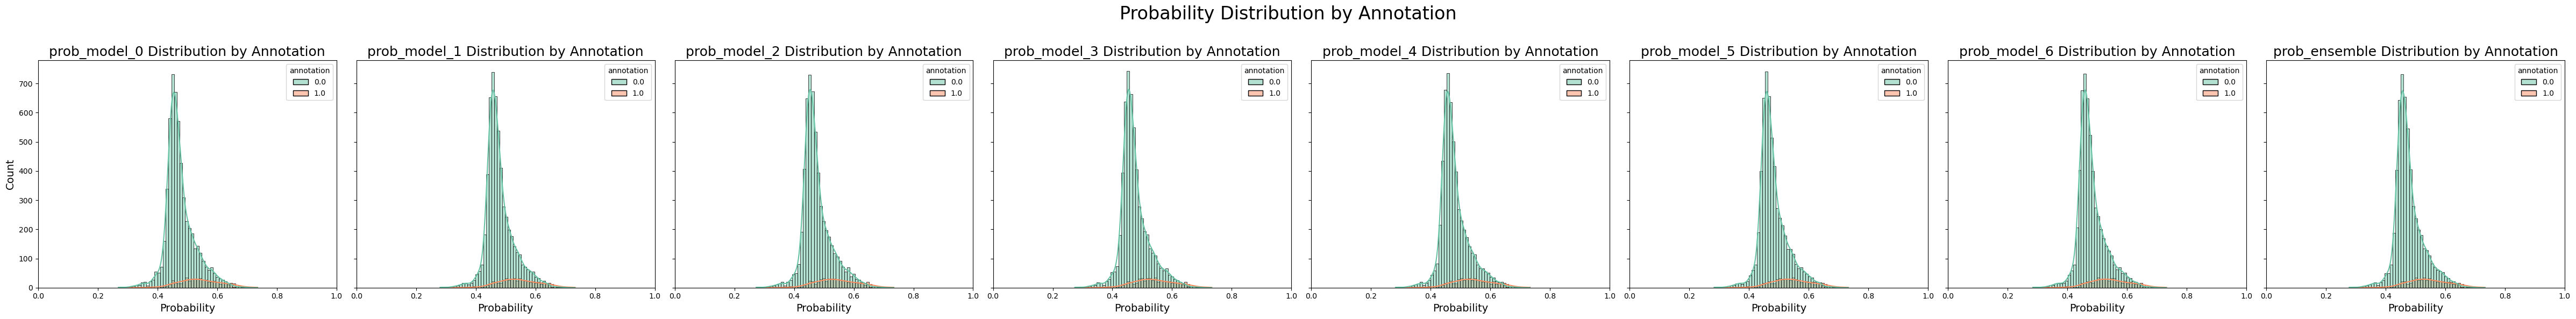

In [11]:
# Probability distribution per annotation (Seaborn, col-wise layout)
_model_cols = model_cols + [ensemble_col]
num_models = len(_model_cols)
fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 6), sharey=True)
fig.suptitle("Probability Distribution by Annotation", fontsize=24)

for i, model_col in enumerate(_model_cols):
    sns.histplot(data=df, x=model_col, hue="annotation", bins=50, kde=True, ax=axes[i], alpha=0.5, palette="Set2")
    axes[i].set_title(f"{model_col} Distribution by Annotation", fontsize=18)
    axes[i].set_xlabel("Probability", fontsize=14)
    axes[i].set_ylabel("Count", fontsize=14)
    axes[i].set_xlim(0.0, 1.0)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

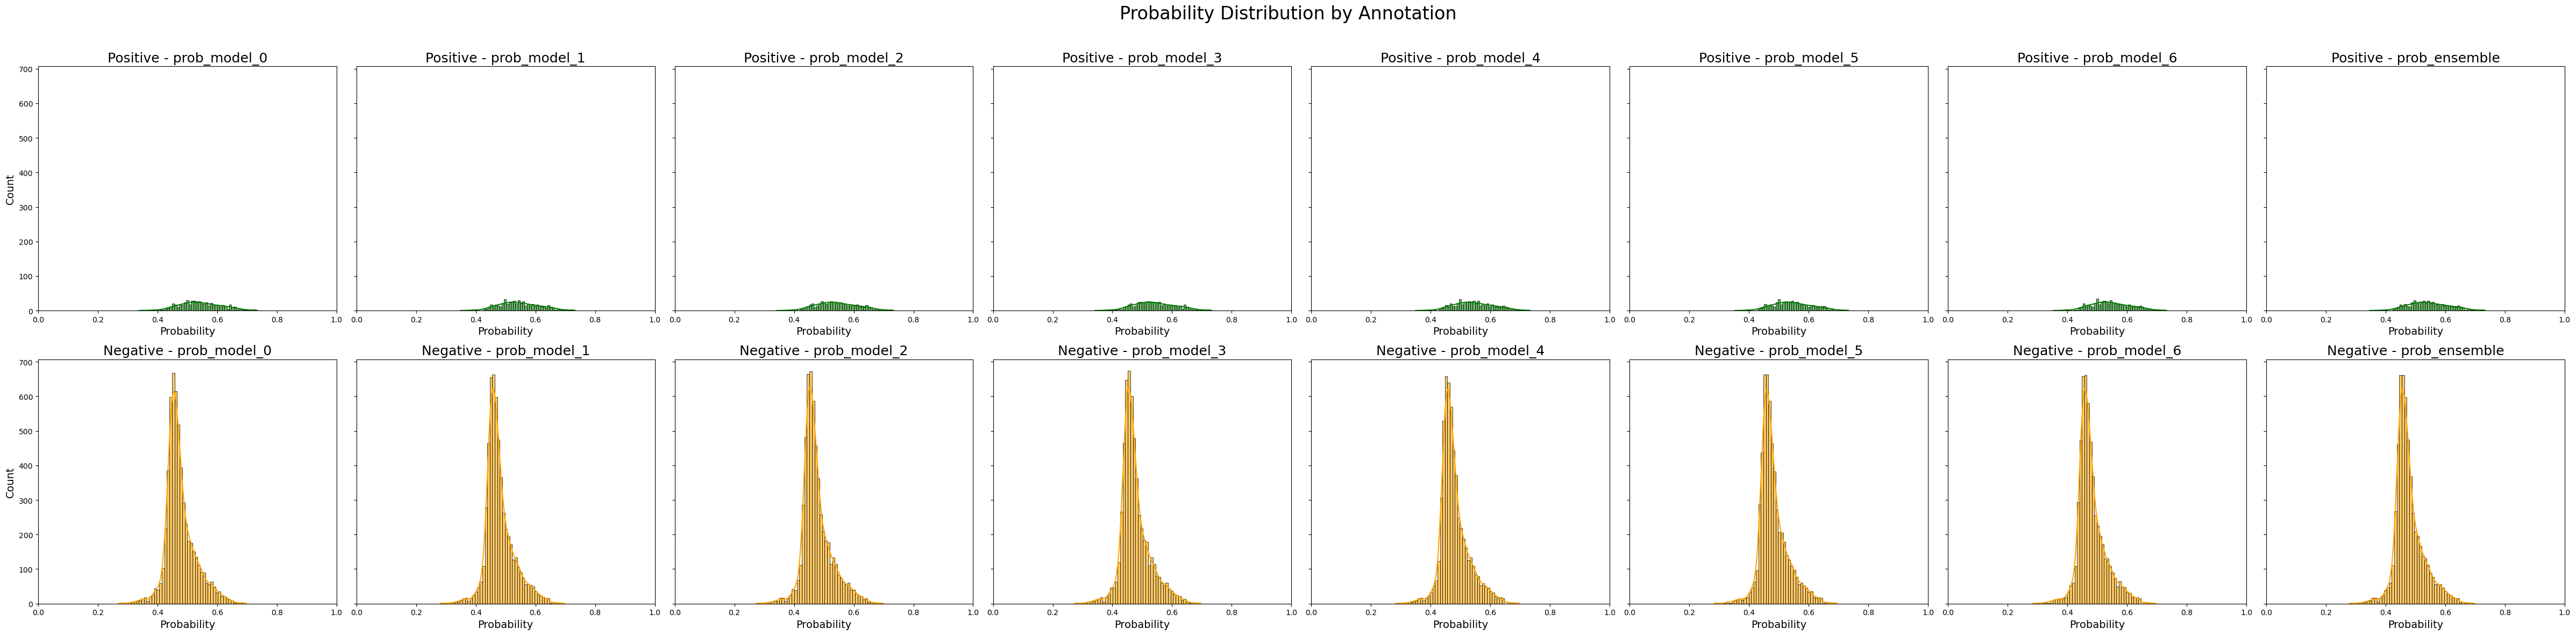

In [12]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
_model_cols = model_cols + [ensemble_col]

# Probability distribution by annotation (Seaborn, row-wise layout)
num_models = len(_model_cols)
fig, axes = plt.subplots(2, num_models, figsize=(6 * num_models, 12), sharey=True)
fig.suptitle("Probability Distribution by Annotation", fontsize=24)

for i, model_col in enumerate(_model_cols):
    # Positive annotation
    sns.histplot(data=df[df['annotation'] == 1], x=model_col, bins=50, kde=True, ax=axes[0, i], alpha=0.6, color="green")
    axes[0, i].set_title(f"Positive - {model_col}", fontsize=18)
    axes[0, i].set_xlabel("Probability", fontsize=14)
    axes[0, i].set_ylabel("Count", fontsize=14)
    axes[0, i].set_xlim(0.0, 1.0)

    # Negative annotation
    sns.histplot(data=df[df['annotation'] == 0], x=model_col, bins=50, kde=True, ax=axes[1, i], alpha=0.6, color="orange")
    axes[1, i].set_title(f"Negative - {model_col}", fontsize=18)
    axes[1, i].set_xlabel("Probability", fontsize=14)
    axes[1, i].set_ylabel("Count", fontsize=14)
    axes[1, i].set_xlim(0.0, 1.0)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


🧮 Entropy Analysis

📝 Entropy Summary
       prob_model_0  prob_model_1  prob_model_2  prob_model_3  prob_model_4  \
count   6163.000000   6163.000000   6163.000000   6163.000000   6163.000000   
mean       0.990220      0.991255      0.990423      0.990553      0.991233   
std        0.015162      0.014144      0.014660      0.014552      0.014002   
min        0.833092      0.837482      0.835928      0.837463      0.838507   
25%        0.989317      0.990739      0.989413      0.989616      0.990528   
50%        0.994626      0.995334      0.994524      0.994699      0.995224   
75%        0.998197      0.998477      0.998129      0.998185      0.998446   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       prob_model_5  prob_model_6  prob_ensemble  
count   6163.000000   6163.000000    6163.000000  
mean       0.991501      0.991604       0.990992  
std        0.013989      0.013805       0.014301  
min        0.837158      0.838309       0.836

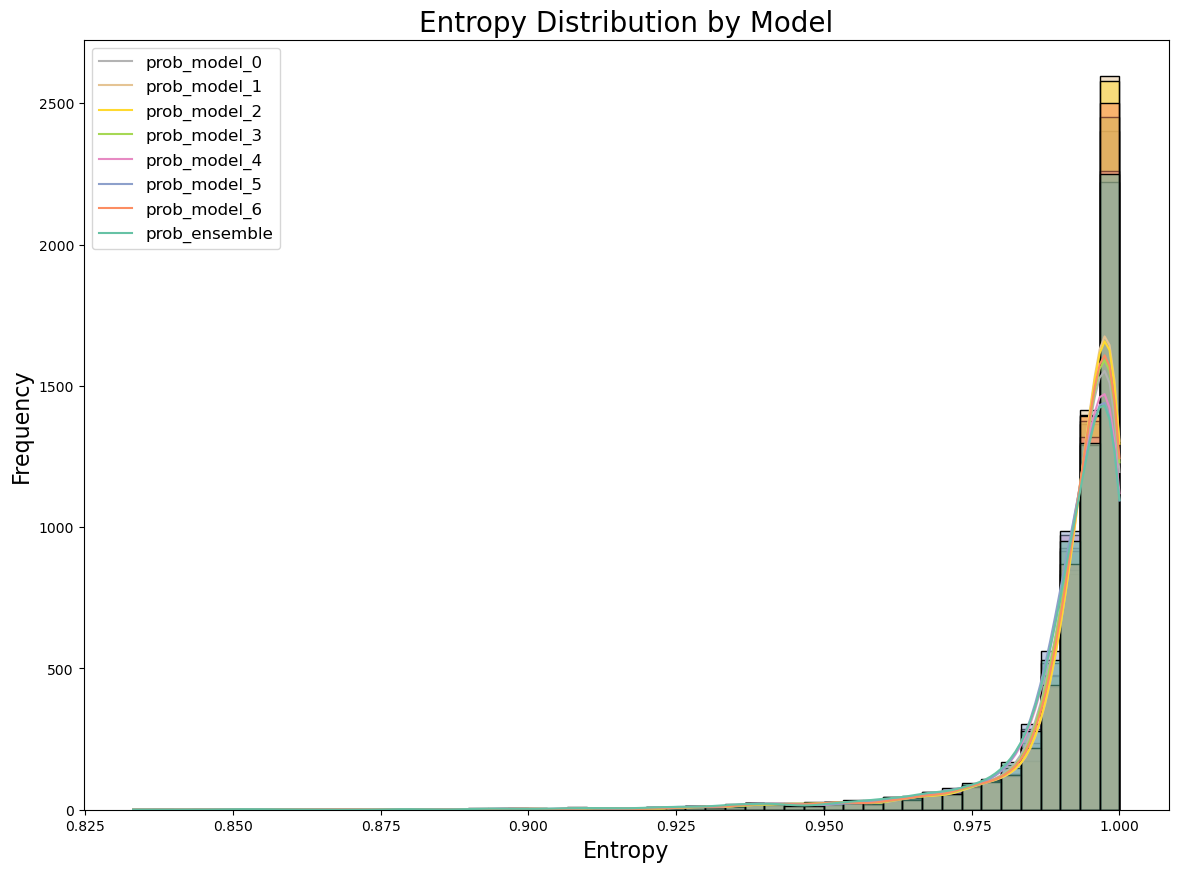

In [13]:
# Entropy calculation
print("\n🧮 Entropy Analysis")
entropy_df = pd.DataFrame()
for col in model_cols + [ensemble_col]:
    probs = df[col].values
    entropies = -(probs * np.log2(probs + 1e-10) + (1 - probs) * np.log2(1 - probs + 1e-10))
    entropy_df[col] = entropies

# Entropy summary
print("\n📝 Entropy Summary")
print(entropy_df.describe())

# Plot entropy distributions (Seaborn)
plt.figure(figsize=(14, 10))
sns.histplot(entropy_df, kde=True, bins=50, alpha=0.5, palette='Set2')
plt.title('Entropy Distribution by Model', fontsize=20)
plt.xlabel('Entropy', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(entropy_df.columns, fontsize=12)
plt.show()

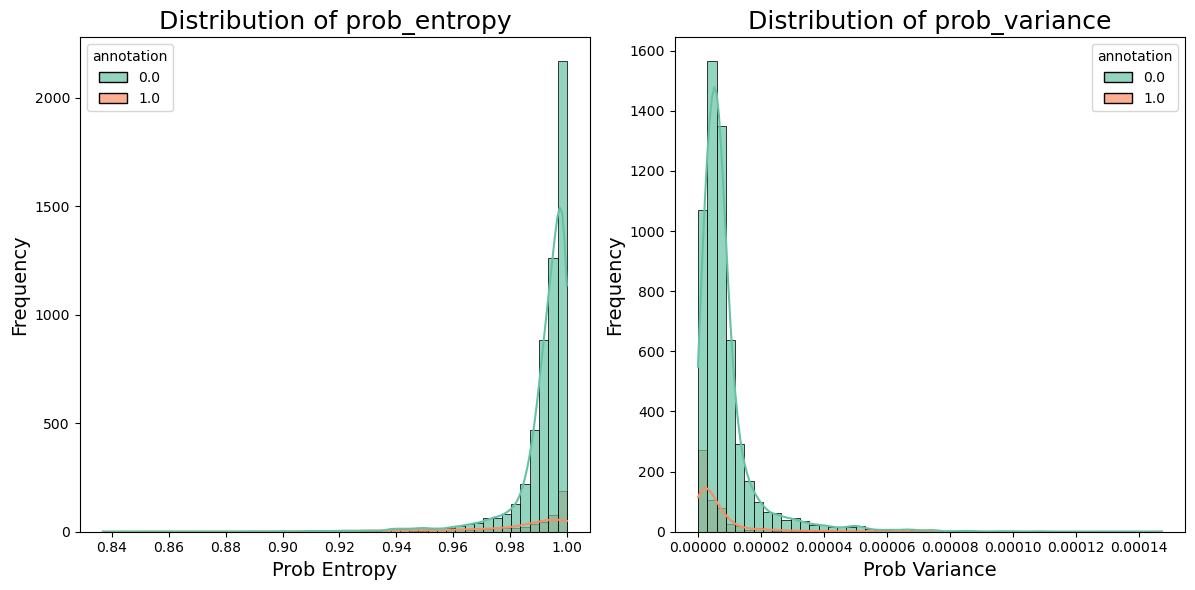


📝 Metric Summary Statistics
       prob_entropy  prob_variance
count   6163.000000   6.163000e+03
mean       0.990970   8.715914e-06
std        0.014307   1.046368e-05
min        0.836848   1.240716e-07
25%        0.990248   3.446685e-06
50%        0.995077   6.100753e-06
75%        0.998372   9.523158e-06
max        0.999999   1.471934e-04


In [14]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
ensemble_col = 'prob_ensemble'
model_cols = [col for col in df.columns if col.startswith('prob_model_')]

# Correct entropy calculation for binary classification
binary_entropies = []
for _, row in df[model_cols].iterrows():
    entropies = - (row.values * np.log2(row.values + 1e-10) + (1 - row.values) * np.log2(1 - row.values + 1e-10))
    binary_entropies.append(np.mean(entropies))

df["prob_entropy"] = binary_entropies
df["prob_variance"] = df[model_cols].var(axis=1)

# Plot distributions
metrics = ["prob_entropy", "prob_variance"]
plt.figure(figsize=(18, 6))
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data=df, x=metric, hue="annotation", bins=50, kde=True, palette="Set2", alpha=0.7)
    plt.title(f"Distribution of {metric}", fontsize=18)
    plt.xlabel(metric.replace('_', ' ').title(), fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n📝 Metric Summary Statistics")
print(df[metrics].describe())

In [15]:
# Sort by entropy, variance, and CV for each annotation
sorted_positive = df[df["annotation"] == 1].sort_values(by="prob_variance", ascending=False)
sorted_negative = df[df["annotation"] == 0].sort_values(by="prob_variance", ascending=False)

# Select top N samples
N = 20
top_positive = sorted_positive.head(N)
top_negative = sorted_negative.head(N)

# Display the selected samples
print("\n🔎 Top Positive Samples (High variance)")
print(top_positive[["annotation", "prob_entropy", "prob_variance"] + model_cols].reset_index(drop=True))

print("\n🔎 Top Negative Samples (High variance)")
print(top_negative[["annotation", "prob_entropy", "prob_variance"] + model_cols].reset_index(drop=True))


🔎 Top Positive Samples (High variance)
    annotation  prob_entropy  prob_variance  prob_model_0  prob_model_1  \
0          1.0      0.996598       0.000082      0.520243      0.536361   
1          1.0      0.989555       0.000081      0.427672      0.442257   
2          1.0      0.990150       0.000073      0.430856      0.445015   
3          1.0      0.979258       0.000059      0.405344      0.418804   
4          1.0      0.983023       0.000055      0.412428      0.426894   
5          1.0      0.997220       0.000054      0.458272      0.472434   
6          1.0      0.995592       0.000051      0.452880      0.463482   
7          1.0      0.993367       0.000050      0.442837      0.453793   
8          1.0      0.999451       0.000047      0.504188      0.514111   
9          1.0      0.986800       0.000042      0.424757      0.435169   
10         1.0      0.986499       0.000041      0.423257      0.433492   
11         1.0      0.999286       0.000041      0.477502   

In [16]:
import pymongo

from data_lake.constants import DB_ADDRESS, TARGET_COLLECTION, TARGET_DB

_CLIENT = pymongo.MongoClient(DB_ADDRESS)
_TARGET_FIELD = {}
_PROJECTION = {field: 1 for field in _TARGET_FIELD}

for _, row in top_positive.iterrows():
    query = {"annotation_id": row.annot_ids}
    nodule_candidates = [x for x in _CLIENT[TARGET_DB][TARGET_COLLECTION].find(query, _PROJECTION)]
    break


In [17]:
nodule_candidates

[{'_id': ObjectId('67f76d769478a54699e0a998'),
  'patient_id': 207954,
  'series_instance_uid': '1.3.6.1.4.1.14519.5.2.1.7009.9004.128719895339498507728437515897',
  'annotation_id': '207954_1_19990102',
  'studydate': 19990102,
  'h5_path_nfs': '/team/team_blu3/lung/data/2_public/LUNA25_h5/1.3.6.1.4.1.14519.5.2.1.7009.9004.128719895339498507728437515897.h5',
  'h5_path': '/nvme1/1_dataset/LUNA25_h5/1.3.6.1.4.1.14519.5.2.1.7009.9004.128719895339498507728437515897.h5',
  'fold': 0,
  'label': 1,
  'age_at_study': 66,
  'gender': 'Female',
  'origin': [-319.29998779296875, -383.6796875, -189.6796875],
  'transform': [[1.7999999523162842, 0.0, 0.0],
   [0.0, 0.640625, 0.0],
   [0.0, 0.0, 0.640625]],
  'spacing': [1.7999999523162842, 0.640625, 0.640625],
  'resampled_spacing': [1.0, 0.67, 0.67],
  'w_coord_zyx': [-206.88, -154.9, -70.47],
  'd_coord_zyx': [62.455550428378594, 357.11951219512196, 186.08341463414635],
  'r_coord_zyx': [112.49757530577511, 341.04563982626127, 177.707840198558